# Modelo de Ising con Cython

(Siguiendo el [tutorial de Jake Vanderplas](http://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/))

Esta parte es el código reducido del [notebook de tutorial](Tutoriales/Cython-Tut.ipynb)

## Código de una simulación del Modelo de Ising

(Siguiendo el [post de Matthew Rocklin](https://matthewrocklin.com/blog/work/2015/02/28/Ising))

[Link al video de Jake VanderPlas (1)](https://www.youtube.com/watch?v=rN7g4gzO2sk)

    for cada_punto in la_red:
        energia = mi_espin * suma_de_todos_los_espines_de_puntos_vecinos
        if energia mejora_cambiando_espin:
            cambia
        else if no_particularmente
            cambia_de_todas_formas
           

### Trabajo Previo

Funciones para crear un campo de espines y para mostrarlo.

In [3]:
import numpy as np

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size = (N, M))

In [2]:
# random_spin_field(10,10)

In [5]:
from PIL import Image

def display_spin_field(field):
    # return Image.fromarray(field) # See docs. fromarray expects numbers 0..255
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255)) # uint8 gives 8bit unassigned integer

In [1]:
# display_spin_field(random_spin_field(200, 200))

## Ising Model

In [7]:
def ising_step(field, beta=0.4):
    N, M = field.shape
    
    # Offset para que no aparezca desplazado diagonalmente (probar con off_step = 1 para ver lo que me refiero)
    off_step = 2
    for n_offset in range(off_step):
        for m_offset in range(off_step):
            for n in range(n_offset, N, off_step):
                for m in range(m_offset, M, off_step):
                    _ising_update(field, n, m, beta)
    return field

#    for n in range(N):
#        for m in range(M):
#            _ising_update(field, n, m, beta)
#    return field

def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

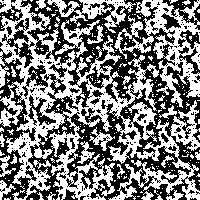

In [8]:
display_spin_field(ising_step(random_spin_field(200, 200), 0.4))

### Animar una secuencia con ipywidgets

In [9]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

Se va a tomar su tiempo en mostrarlo, estamos haciendo 6 bucles y python no está optimizado

In [10]:
images = [random_spin_field(200, 200)]

for i in range(5):
    images.append(ising_step(images[-1].copy()))
display_ising_sequence(images)

interactive(children=(IntSlider(value=2, description='frame', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 5))>

Tarda, pero ¡ya está!
El modelo de Ising en python.

## Usar Cython para mejorar su rendimiento

[Link al vídeo de Jake Vanderplas (2)](https://www.youtube.com/watch?v=LOzcSuw3yOY&feature=emb_title)

Nota:
Para usar `cython` en Windows es necesario tener C++ instalado, por ejemplo a través de Visual Studio Build Tools. Si no, saldrá un error `unable to find vcvarsall.bat`.
Más detalles y la solución que me ha servido en [este enlace](https://stackoverflow.com/questions/53172601/error-unable-to-find-vcvarsall-bat-when-compiling-cython-code)

Extensión para hacer cython fácilmente en un notebook:

In [11]:
%load_ext Cython

Sólo con añadir `%cython` ya mejora la velocidad un 10%.

Pero para mejorar realmente el código de antes, tenemos que añadir tipos a todas las variables.

In [12]:
%%cython

cimport cython

import numpy as np
cimport numpy as cnp

from libc.math cimport exp 
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

cpdef cy_ising_step(cnp.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta)
    return np.array(field)

cdef _cy_ising_update(cnp.int64_t[:, :] field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

A veces en el siguiente paso sale el error `name error: cy_ising_step not defined`, que solucioné usando `cpdef` en la declaración según [esta respuesta de StackExchange](https://stackoverflow.com/questions/23658653/cythons-cdef-raises-a-nameerror-where-a-def-works-just-fine).

Tengo que leer más sobre cython.

In [13]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(np.int64(field))

534 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.49 ms ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


El flag `%cython -a` nos "anota" dónde está tomando más tiempo, para que podamos optimizar. 

Al hacer cosas con cython hay que importar las librerias de nuevo.

```python
from libc.math cimport exp 
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX
```
Estas tres lineas son para mejorar el rendimiento de `_cy_ising_update` usando directamente las funciones exponencial y random de C++. `RAND_MAX` lo sacamos de limits.h y lo usamos porque rand() de C++ da un número entre 0 y `RAND_MAX`.

Parece que los comentarios no le gustan a cython porque # es un caracter reservado en C++. ¿?

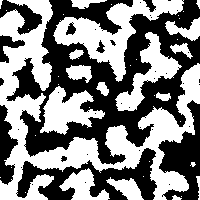

In [14]:
display_spin_field(field)

In [15]:
images = [random_spin_field(200, 200)]

for i in range(30):
    images.append(cy_ising_step(np.int64(images[-1].copy()), 0.6))
display_ising_sequence(np.int64(images))

interactive(children=(IntSlider(value=15, description='frame', max=30), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 30))>

## Propio: Más interactividad

A ver si ahora consigo poner dos sliders, el segundo para cambiar $\beta$.

### Dos widgets de slider

In [16]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display
def f(a, b):
    display(a+b)
    return a+b

In [17]:
w = interactive(f, a=10, b=20)

In [18]:
w.children

(IntSlider(value=10, description='a', max=30, min=-10),
 IntSlider(value=20, description='b', max=60, min=-20),
 Output())

In [19]:
display(w)

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

### Mi intento en el tema

In [20]:
from ipywidgets import interact

def dob_display_ising_sequence(images, nbet, nframe):
    def _show(frame=(0, nframe - 1), beta = (0, nbet-1)):
        return display_spin_field(images[beta][frame])
    return interact(_show)

In [21]:
init = random_spin_field(400, 400)
nbet = 10
nframe = 20

img = np.ndarray((nbet, nframe), dtype = object)
for be in range(nbet):
    img[be][0] = init
    for i in range(1,nframe):
        img[be][i]=(cy_ising_step(np.int64(img[be][i-1].copy()), (be+1)/10))


In [22]:
dob_display_ising_sequence(img, nbet, nframe)

interactive(children=(IntSlider(value=9, description='frame', max=19), IntSlider(value=4, description='beta', …

<function __main__.dob_display_ising_sequence.<locals>._show(frame=(0, 19), beta=(0, 9))>

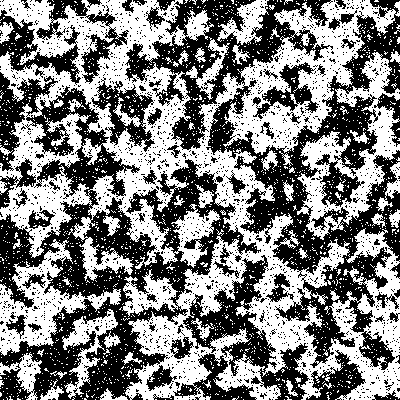

In [23]:
display_spin_field(img[1][9])

# Ising Model in depth

From [here](https://rajeshrinet.github.io/blog/2014/ising-model/)

In [3]:
from __future__ import division
%matplotlib inline
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

In [4]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------
def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state


def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

In [5]:

## change these parameters for a smaller (faster) simulation 
nt      = 88         #  number of temperature points
N       = 16         #  size of the lattice, N x N
eqSteps = 1024       #  number of MC sweeps for equilibration
mcSteps = 1024       #  number of MC sweeps for calculation

T       = np.linspace(1.53, 3.28, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get intensive values

In [ ]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate(N)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

In [ ]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');